<a href="https://colab.research.google.com/github/juanrueda5/Magnetic-Domains-With-Machine-Learning/blob/main/CNNTorch_MagDom3param.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
import numpy as np
import cv2
import io
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import zipfile
import PIL

In [ ]:

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from tqdm import tqdm
cudnn.benchmark = True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
from tempfile import TemporaryDirectory

# **Define Device**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Transformations**

In [ ]:
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            transforms.Resize((450, 450)),
            transforms.ToTensor(),
            ]),
    'val': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize((450, 450)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]),
}

# **Image Augmentation**

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image

# Define the directory for the input and output images
input_dir = '/content/drive/MyDrive/CroppedImages/val/'
output_dir = '/content/drive/MyDrive/CroppedImages/trial/'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 1: Define transformations
my_transform = transforms.Compose([
    transforms.Resize((450, 450)),
    transforms.RandomCrop((360,360)),
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.RandomRotation(degrees=45),     # Random rotation
    transforms.ColorJitter(brightness = 0.5),
    transforms.RandomGrayscale(p=0.3),        # Random grayscale# Convert to tensor
])

list_img = os.listdir(input_dir)
for img in list_img:
  image = Image.open(input_dir + img)
  image = my_transform(image)
  image.save(output_dir + img.replace('.png','') + 'tr_.png')



KeyboardInterrupt: 

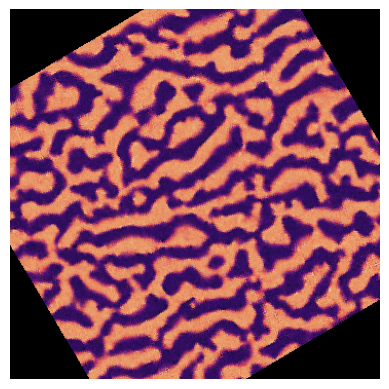

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
input_path = '/content/drive/MyDrive/CroppedImages/val/'
list_img = os.listdir(input_path)
for img in list_img:
  imagen = Image.open(input_path + img)
  imagen.crop((55,55, 467, 510))
  imagen.save(input_path + img.replace('.png','') + 'crop.png')
plt.imshow(imagen)
plt.axis('off')
plt.show()



# **Read Images on ZipFiles**

In [ ]:
class ZipDataset():
    def __init__(self, root_path, var,trns, cache_into_memory=False):
        if cache_into_memory:
            f = open(root_path, 'rb')
            self.zip_content = f.read()
            f.close()
            self.zip_file = zipfile.ZipFile(io.BytesIO(self.zip_content), 'r')
        else:
            self.zip_file = zipfile.ZipFile(root_path, 'r')
        self.name_list = list(filter(lambda x: var in x, self.zip_file.namelist()))
        self.to_tensor = ToTensor()
        self.transf = trns[var]
    def __getitem__(self, key):
        buf = self.zip_file.read(name=self.name_list[key])
        img = cv2.imdecode(np.frombuffer(buf, dtype=np.uint8), cv2.IMREAD_COLOR)
        img = PIL.Image.fromarray(img)
        values = self.name_list[key].split('_')
        Ms = float(values[0].split('/')[-1])
        Aex = float(values[1])
        keff = float(values[2])
        alpha = float(values[3])
        maxMs = 1900000.0
        maxAex = 2.4999999999999998e-11
        maxkeff = 1000000.0
        maxalpha = 0.95
        target = [Ms/maxMs, keff/maxkeff]
        target = torch.tensor(target, dtype=torch.float32)
        img = self.transf(img)
        return img, target

    def __len__(self):
        return len(self.name_list)

In [ ]:
path1= '/content/drive/MyDrive/FinalDataMD/CroppedImages.zip'
ZipDataset(root_path=path1, var='train', trns=data_transforms).__getitem__(0)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([1.0000, 0.4000]))

In [ ]:
num_steps = 100
batch_size =128
num_epochs = 200

dtype = torch.float# Torch Variables

In [ ]:
dataset_train = ZipDataset(root_path = path1,var='train', trns = data_transforms, cache_into_memory=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = ZipDataset(path1,var='val',trns = data_transforms,cache_into_memory=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
image_datasets = {'train': dataset_train, 'val': dataset_val}
dataloaders = {'train': dataloader_train, 'val': dataloader_val}
dataset_sizes = {'train': len(image_datasets['train']),'val': len(image_datasets['val'])}
print(dataset_sizes)

{'train': 406, 'val': 106}


In [ ]:
net = nn.Sequential(nn.Conv2d(1, 32, 3),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, 3),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(128, 256),
                    nn.Linear(256,128),
                    nn.Linear(128,64),
                    nn.Linear(64,2),
                    ).to(device)

# **Optimizer, Scheduler, Loss**

In [ ]:
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
scheduler = lr_scheduler.MultiStepLR(optimizer,
                        milestones=[8, 24, 28], # List of epoch indices
                        gamma =0.5) # Multiplicative factor of learning rate decay

# **Train Loop**

In [ ]:
from torcheval.metrics import R2Score
R2list = []
MAElist = []
losslist = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=500):
    R2 = R2Score()
    MAE = nn.L1Loss()
    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_R2 = -1000000000000000.0
        best_MAE = 100000000000000.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase],leave=False):
                    try:
                      inputs = inputs.to(device)
                      labels = labels.to(device)

                      # zero the parameter gradients
                      optimizer.zero_grad()

                      # forward
                      # track history if only in train
                      with torch.set_grad_enabled(phase == 'train'):
                          outputs = model(inputs)
                          _, preds = torch.max(outputs, 0)
                          loss = criterion(outputs, labels)

                          # backward + optimize only if in training phase
                          if phase == 'train':
                              loss.backward()
                              optimizer.step()
                    except Exception as e:
                      pass
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                R2.update(outputs, labels)
                epoch_R2 = R2.compute()
                epoch_MAE = MAE(outputs, labels)
                R2list.append(epoch_R2)
                losslist.append(epoch_loss)
                MAElist.append(epoch_MAE)
                print(f'{phase} Loss: {epoch_loss:.4f} R2Score: {epoch_R2:.4f} MAE: {epoch_MAE:.4f}')

                # deep copy the model
                if phase == 'val':
                  if epoch_R2 > best_R2:
                    best_R2 = epoch_R2
                    torch.save(model.state_dict(), best_model_params_path)
                  if epoch_MAE < best_MAE:
                    best_MAE = epoch_MAE
            print()
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val R2: {best_R2:4f}', best_R2)
        print(f'Best val MAE: {best_MAE:4f}')

        # load best model weights

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
param_path='/content/drive/MyDrive/MagDomWeights/MagDomHuber2param500R2epoch.pth'
trained_net = train_model(net,criterion,optimizer,scheduler)
torch.save(trained_net.state_dict(),param_path )

Epoch 0/499
----------


train Loss: 0.0243 R2Score: 0.3224 MAE: 0.1633


val Loss: 0.0236 R2Score: 0.4040 MAE: 0.1718

Epoch 1/499
----------


train Loss: 0.0238 R2Score: 0.4119 MAE: 0.1807


val Loss: 0.0238 R2Score: 0.4141 MAE: 0.1700

Epoch 2/499
----------


train Loss: 0.0223 R2Score: 0.4111 MAE: 0.1713


val Loss: 0.0232 R2Score: 0.4139 MAE: 0.1682

Epoch 3/499
----------


train Loss: 0.0231 R2Score: 0.4180 MAE: 0.1306


val Loss: 0.0245 R2Score: 0.4153 MAE: 0.1727

Epoch 4/499
----------


KeyboardInterrupt: 

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
net.load_state_dict(torch.load('/content/drive/MyDrive/MagDomWeights/MagDomHuber2param500R2epoch.pth'))
img_path = '/content/drive/MyDrive/CroppedImages/train/'
list_img = os.listdir(img_path)[50]

img = Image.open(img_path + list_img)
if img.mode != 'RGB':
      img = img.convert('RGB')
values = list_img.split('_')
Ms = float(values[0].split('/')[-1])
Aex = float(values[1])
keff = float(values[2])
alpha = float(values[3])
maxMs = 1900000.0
maxAex = 2.4999999999999998e-11
maxkeff = 1000000.0
maxalpha = 0.95
target = [Ms/maxMs, keff/maxkeff]
net.eval()
img = data_transforms['val'](img)
img = img.unsqueeze(0)
img = img.to(device)
with torch.no_grad():
      outputs = net(img)
      ax = plt.subplot(2,2,1)
      ax.axis('off')
      ax.set_title(f'Predicted: {outputs} Target: {target}')
      plt.imshow(img.cpu().data[0].squeeze(0))


In [ ]:
from torch import is_tensor

x = np.arange(0,len(MAElist),1)
print(len(MAElist))
print(len(R2list))

for i in range(0,len(MAElist)):
  if is_tensor(R2list[i]):
    R2list[i] = R2list[i].item()
  if is_tensor(MAElist[i]):
    MAElist[i] = MAElist[i].item()
plt.scatter(x,R2list)
plt.show()
plt.scatter(x,MAElist)
plt.show()
plt.scatter(x,losslist)
plt.show()
